# Model Inference


# 1. Import Libraries


In [1]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.nn as nn
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
from IPython.display import display

# 2. Define Model Architectures


In [2]:
def build_resnet50_classifier(num_classes=23):
    """Build ResNet50 model architecture"""
    model = models.resnet50(weights=None)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    return model

def build_efficientnet_classifier(num_classes=23):
    """Build EfficientNet-B0 model architecture"""
    model = models.efficientnet_b0(weights=None)
    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
    return model


In [3]:
class CNN20Model(nn.Module):
    """Custom 20-layer CNN Model (matches FirstDraft architecture)"""
    def __init__(self, num_classes=23):
        super(CNN20Model, self).__init__()

        # Convolutional Layers
        self.features = nn.Sequential(
            # Block 1 (Input: 3x224x224 -> Output: 64x112x112)
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2 (Output: 128x56x56)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3 (Output: 256x28x28)
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4 (Output: 512x14x14)
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5 (Output: 512x7x7)
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Classifier (Fully Connected Layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(4096, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(1000, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 3. Save Model Function


In [4]:
def save_model_with_metadata(model, history, model_name, num_classes, class_to_idx):
    """
    Save model with complete metadata.

    Args:
        model: Trained PyTorch model
        history: Dictionary with training history (train_loss, train_acc, val_loss, val_acc)
        model_name: Name of the model (e.g., 'resnet50', 'efficientnet_b0')
        num_classes: Number of classes
        class_to_idx: Dictionary mapping class names to indices
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'history': history,
        'num_classes': num_classes,
        'class_to_idx': class_to_idx,
        'model_name': model_name
    }
    filename = f'{model_name}_complete.pth'
    torch.save(checkpoint, filename)
    print(f"✓ Saved {model_name} to '{filename}'")

# Example usage (from training notebook):
# save_model_with_metadata(resnet_model, resnet_history, 'resnet50',
#                          len(idx_to_class), class_to_idx)
# save_model_with_metadata(efficientnet_model, efficientnet_history, 'efficientnet_b0',
#                          len(idx_to_class), class_to_idx)


# 4. Load Model Function


In [5]:
def load_model(model_path, device='cpu'):
    """
    Load a trained PyTorch model with backward compatibility.

    Supports three formats:
    1. Complete checkpoint (with metadata: model_state_dict, history, class_to_idx, etc.)
    2. Legacy checkpoint (weights only: state_dict)
    3. CNN-20 custom model

    Args:
        model_path: Path to the saved model checkpoint
        device: Device to load the model on ('cpu' or 'cuda')

    Returns:
        tuple: (model, class_to_idx, idx_to_class, history)
    """
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")

    print(f"Loading model from: {model_path}")

    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)

    # Check if it's a complete checkpoint or just weights
    is_complete = isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint

    history = None  # Initialize history

    if is_complete:
        # ========== Complete checkpoint format ==========
        print("→ Detected: Complete checkpoint (with metadata)")

        # Extract metadata
        num_classes = checkpoint['num_classes']
        model_name = checkpoint['model_name']
        class_to_idx = checkpoint['class_to_idx']
        history = checkpoint.get('history', None)  # Extract history if available

        # Build model architecture
        if 'resnet' in model_name.lower():
            model = build_resnet50_classifier(num_classes)
        elif 'efficientnet' in model_name.lower():
            model = build_efficientnet_classifier(num_classes)
        elif 'cnn' in model_name.lower() or '20' in model_name.lower():
            model = CNN20Model(num_classes)
        else:
            raise ValueError(f"Unknown model type: {model_name}")

        # Load trained weights
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        model.eval()

        # Create idx_to_class mapping
        idx_to_class = {v: k for k, v in class_to_idx.items()}

        print(f"✓ Loaded {model_name} with {num_classes} classes")
        if history:
            print(f"✓ Training history loaded ({len(history.get('train_loss', []))} epochs)")

    else:
        # ========== Legacy checkpoint format (weights only) ==========
        print("→ Detected: Legacy checkpoint (weights only)")

        # Infer num_classes and model type from the weights
        if 'fc.weight' in checkpoint:  # ResNet50
            num_classes = checkpoint['fc.weight'].shape[0]
            model_type = 'resnet50'
            print(f"→ Detected model type: ResNet50")
            model = build_resnet50_classifier(num_classes)
        elif 'classifier.1.weight' in checkpoint:  # EfficientNet
            num_classes = checkpoint['classifier.1.weight'].shape[0]
            model_type = 'efficientnet'
            print(f"→ Detected model type: EfficientNet-B0")
            model = build_efficientnet_classifier(num_classes)
        elif 'classifier.10.weight' in checkpoint:  # CNN-20 (check for final layer)
            num_classes = checkpoint['classifier.10.weight'].shape[0]
            model_type = 'cnn20'
            print(f"→ Detected model type: CNN-20")
            model = CNN20Model(num_classes)
        else:
            raise ValueError("Cannot determine model type from checkpoint keys")

        # Load weights
        model.load_state_dict(checkpoint)
        model.to(device)
        model.eval()

        # Reconstruct class mapping from CLEAN_DIR
        print(f"→ Reconstructing class mappings from dataset...")

        # Try to find CLEAN_DIR
        ROOT = Path().resolve()
        CLEAN_DIR = os.path.join(ROOT, "data", "clean")

        if os.path.exists(CLEAN_DIR):
            clean_dataset = torchvision.datasets.ImageFolder(root=CLEAN_DIR)
            class_to_idx = clean_dataset.class_to_idx
            idx_to_class = {v: k for k, v in class_to_idx.items()}
            print(f"✓ Reconstructed class mappings from {CLEAN_DIR}")
        else:
            print(f"⚠ Warning: {CLEAN_DIR} not found")
            print(f"→ Creating placeholder class mappings (0-{num_classes-1})")
            class_to_idx = {f"class_{i}": i for i in range(num_classes)}
            idx_to_class = {i: f"class_{i}" for i in range(num_classes)}

        print(f"✓ Loaded legacy checkpoint with {num_classes} classes")
        print(f"⚠ No training history available (legacy format)")

    return model, class_to_idx, idx_to_class, history

# 5. Load Models


In [6]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model paths
ROOT = Path().resolve()
RESNET_MODEL_PATH = os.path.join(ROOT, "resnet50_complete.pth")
EFFICIENTNET_MODEL_PATH = os.path.join(ROOT, "efficientnet_b0_complete.pth")
CNN20_MODEL_PATH = os.path.join(ROOT, "cnn_20_complete.pth")

# Load models WITH HISTORY
print("\nLoading ResNet50...")
resnet_model, resnet_class_to_idx, resnet_idx_to_class, resnet_history = load_model(RESNET_MODEL_PATH, device)

print("\nLoading EfficientNet-B0...")
efficientnet_model, efficientnet_class_to_idx, efficientnet_idx_to_class, efficientnet_history = load_model(EFFICIENTNET_MODEL_PATH, device)

print("\nLoading CNN-20...")
cnn20_model, cnn20_class_to_idx, cnn20_idx_to_class, cnn20_history = load_model(CNN20_MODEL_PATH, device)

print("\n✓ All models loaded successfully!")

Using device: cuda

Loading ResNet50...
Loading model from: Q:\Users\zgl-7\Source\Repos\DS3000-25fall\resnet50_complete.pth
→ Detected: Complete checkpoint (with metadata)
✓ Loaded resnet50 with 23 classes
✓ Training history loaded (29 epochs)

Loading EfficientNet-B0...
Loading model from: Q:\Users\zgl-7\Source\Repos\DS3000-25fall\efficientnet_b0_complete.pth
→ Detected: Complete checkpoint (with metadata)
✓ Loaded efficientnet_b0 with 23 classes
✓ Training history loaded (15 epochs)

Loading CNN-20...
Loading model from: Q:\Users\zgl-7\Source\Repos\DS3000-25fall\cnn_20_complete.pth
✓ Loaded resnet50 with 23 classes
✓ Training history loaded (29 epochs)

Loading EfficientNet-B0...
Loading model from: Q:\Users\zgl-7\Source\Repos\DS3000-25fall\efficientnet_b0_complete.pth
→ Detected: Complete checkpoint (with metadata)
✓ Loaded efficientnet_b0 with 23 classes
✓ Training history loaded (15 epochs)

Loading CNN-20...
Loading model from: Q:\Users\zgl-7\Source\Repos\DS3000-25fall\cnn_20_com

## 5.1 Setup Validation Data Loader

In [7]:
# Configuration
ROOT = Path().resolve()
CLEAN_DIR = os.path.join(ROOT, "data", "clean")
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 4
PIN = torch.cuda.is_available()

# Image transformations for validation
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

val_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Create validation dataset and loader
print(f"Loading validation dataset from: {CLEAN_DIR}")
val_dataset = torchvision.datasets.ImageFolder(root=CLEAN_DIR, transform=val_transform)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE * 2, 
    shuffle=False,
    num_workers=NUM_WORKERS, 
    pin_memory=PIN, 
    drop_last=False
)

# Get class mappings
class_to_idx = val_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

print(f"✓ Validation dataset loaded")
print(f"  Total images: {len(val_dataset)}")
print(f"  Number of classes: {len(idx_to_class)}")
print(f"  Batch size: {BATCH_SIZE * 2}")

Loading validation dataset from: Q:\Users\zgl-7\Source\Repos\DS3000-25fall\data\clean
✓ Validation dataset loaded
  Total images: 35386
  Number of classes: 23
  Batch size: 64


# 6. Training Curves Visualization

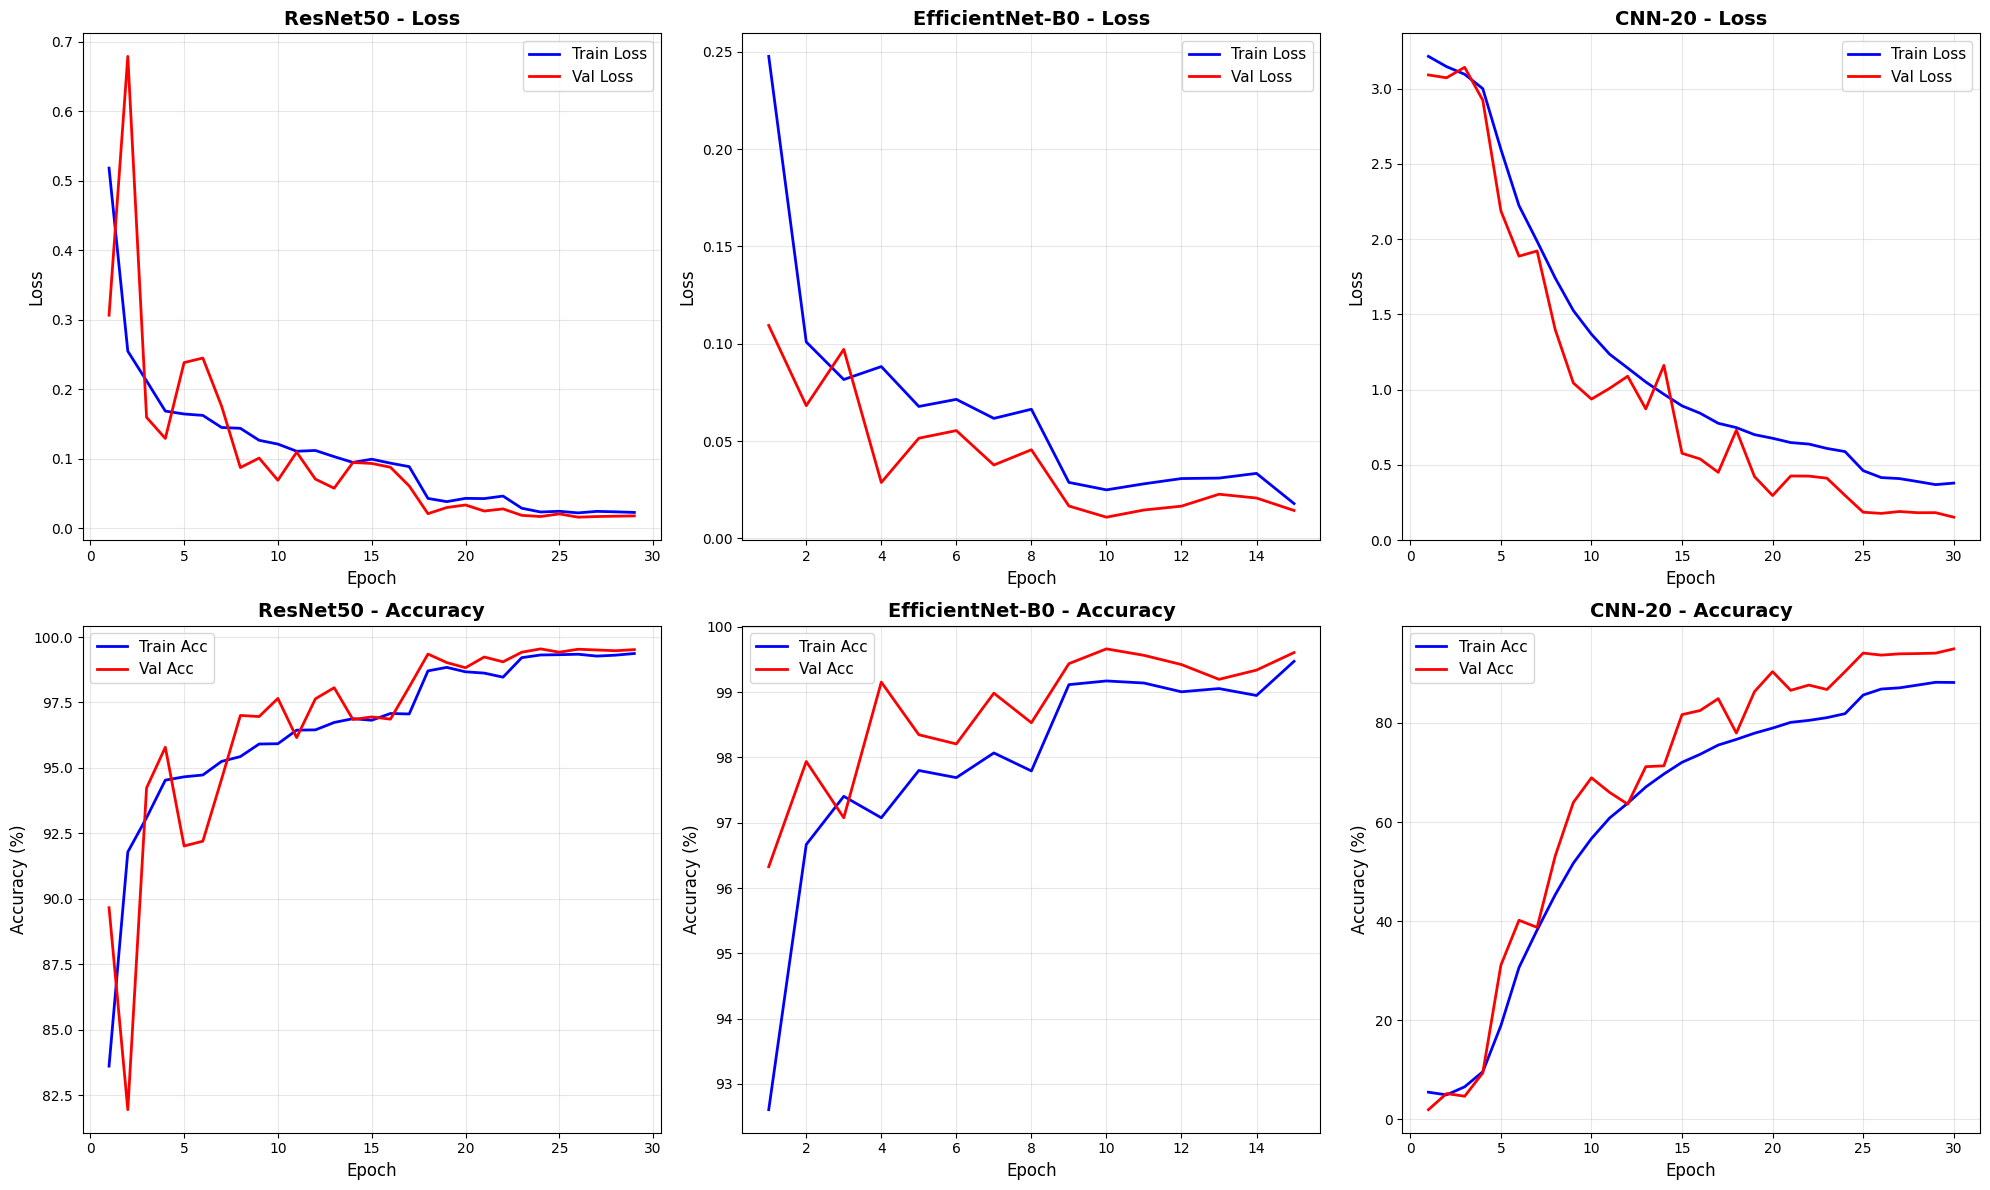

✓ Training history comparison plotted


In [8]:
# Plot Training Histories Comparison (Side-by-Side)
import matplotlib.gridspec as gridspec

def plot_training_histories_comparison(history1, history2, history3, model_name1, model_name2, model_name3):
    """Compare training histories of three models side by side"""
    fig = plt.figure(figsize=(20, 12))
    gs = gridspec.GridSpec(2, 3, figure=fig)

    epochs1 = range(1, len(history1['train_loss']) + 1)
    epochs2 = range(1, len(history2['train_loss']) + 1)
    epochs3 = range(1, len(history3['train_loss']) + 1)

    # Model 1 - Loss
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(epochs1, history1['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs1, history1['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax1.set_title(f'{model_name1} - Loss', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Model 2 - Loss
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(epochs2, history2['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax2.plot(epochs2, history2['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax2.set_title(f'{model_name2} - Loss', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    # Model 3 - Loss
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(epochs3, history3['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax3.plot(epochs3, history3['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax3.set_title(f'{model_name3} - Loss', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Loss', fontsize=12)
    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)

    # Model 1 - Accuracy
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.plot(epochs1, history1['train_acc'], 'b-', label='Train Acc', linewidth=2)
    ax4.plot(epochs1, history1['val_acc'], 'r-', label='Val Acc', linewidth=2)
    ax4.set_title(f'{model_name1} - Accuracy', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Accuracy (%)', fontsize=12)
    ax4.set_xlabel('Epoch', fontsize=12)
    ax4.legend(fontsize=11)
    ax4.grid(True, alpha=0.3)

    # Model 2 - Accuracy
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.plot(epochs2, history2['train_acc'], 'b-', label='Train Acc', linewidth=2)
    ax5.plot(epochs2, history2['val_acc'], 'r-', label='Val Acc', linewidth=2)
    ax5.set_title(f'{model_name2} - Accuracy', fontsize=14, fontweight='bold')
    ax5.set_ylabel('Accuracy (%)', fontsize=12)
    ax5.set_xlabel('Epoch', fontsize=12)
    ax5.legend(fontsize=11)
    ax5.grid(True, alpha=0.3)

    # Model 3 - Accuracy
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.plot(epochs3, history3['train_acc'], 'b-', label='Train Acc', linewidth=2)
    ax6.plot(epochs3, history3['val_acc'], 'r-', label='Val Acc', linewidth=2)
    ax6.set_title(f'{model_name3} - Accuracy', fontsize=14, fontweight='bold')
    ax6.set_ylabel('Accuracy (%)', fontsize=12)
    ax6.set_xlabel('Epoch', fontsize=12)
    ax6.legend(fontsize=11)
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Check if all models have training history
if resnet_history and efficientnet_history and cnn20_history:
    plot_training_histories_comparison(resnet_history, efficientnet_history, cnn20_history, 
                                      'ResNet50', 'EfficientNet-B0', 'CNN-20')
    print("✓ Training history comparison plotted")
else:
    print("⚠ Cannot plot comparison: One or more models missing training history")
    if not resnet_history:
        print("  - ResNet50: No history")
    if not efficientnet_history:
        print("  - EfficientNet-B0: No history")
    if not cnn20_history:
        print("  - CNN-20: No history")

## 6.1 Training History Summary

In [9]:
# Display Training History
print("=" * 70)
print("TRAINING HISTORY SUMMARY")
print("=" * 70)

for model_name, history in [("ResNet50", resnet_history), 
                              ("EfficientNet-B0", efficientnet_history), 
                              ("CNN-20", cnn20_history)]:
    if history:
        print(f"\n{model_name}:")
        print(f"  Epochs trained: {len(history['train_loss'])}")
        print(f"  Best val accuracy: {max(history['val_acc']):.2f}%")
        print(f"  Final train loss: {history['train_loss'][-1]:.4f}")
        print(f"  Final val loss: {history['val_loss'][-1]:.4f}")
    else:
        print(f"\n{model_name}: No training history available")

TRAINING HISTORY SUMMARY

ResNet50:
  Epochs trained: 29
  Best val accuracy: 99.55%
  Final train loss: 0.0225
  Final val loss: 0.0175

EfficientNet-B0:
  Epochs trained: 15
  Best val accuracy: 99.66%
  Final train loss: 0.0179
  Final val loss: 0.0143

CNN-20:
  Epochs trained: 30
  Best val accuracy: 94.94%
  Final train loss: 0.3792
  Final val loss: 0.1527


# 7. Model Evaluation Function

In [17]:
def evaluate_model_pytorch(model, loader, device, k=3):
    """
    Evaluate PyTorch model and return comprehensive metrics.
    
    Args:
        model: Trained PyTorch model
        loader: DataLoader for validation data
        device: Device to run evaluation on
        k: Top-k accuracy parameter (default: 3)
    
    Returns:
        dict: Dictionary containing loss, accuracy, top-k accuracy, predictions, probabilities, and labels
    """
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    total_loss = 0.0
    correct = 0
    total = 0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / total
    accuracy = 100. * correct / total

    # Calculate top-k accuracy
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    top_k_acc = top_k_accuracy_score(all_labels, all_probs, k=k) * 100

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'top_k_accuracy': top_k_acc,
        'predictions': np.array(all_preds),
        'probabilities': all_probs,
        'labels': all_labels
    }

print("✓ Evaluation function loaded")

✓ Evaluation function loaded


# 8. Evaluate All Models and Compare Performance

In [11]:
print("Evaluating ResNet50...")
resnet_results = evaluate_model_pytorch(resnet_model, val_loader, device, k=3)
print(f"  ✓ Accuracy: {resnet_results['accuracy']:.2f}%")

print("\nEvaluating EfficientNet-B0...")
efficientnet_results = evaluate_model_pytorch(efficientnet_model, val_loader, device, k=3)
print(f"  ✓ Accuracy: {efficientnet_results['accuracy']:.2f}%")

print("\nEvaluating CNN-20...")
cnn20_results = evaluate_model_pytorch(cnn20_model, val_loader, device, k=3)
print(f"  ✓ Accuracy: {cnn20_results['accuracy']:.2f}%")

# Create comparison table
results_df = pd.DataFrame({
    'Model': ['ResNet50', 'EfficientNet-B0', 'CNN-20'],
    'Validation Loss': [resnet_results['loss'], efficientnet_results['loss'], cnn20_results['loss']],
    'Validation Accuracy (%)': [resnet_results['accuracy'], efficientnet_results['accuracy'], cnn20_results['accuracy']],
    'Top-3 Accuracy (%)': [resnet_results['top_k_accuracy'], efficientnet_results['top_k_accuracy'], cnn20_results['top_k_accuracy']]
})

print("\n" + "=" * 70)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 70)
display(results_df.style.format({
    'Validation Loss': '{:.4f}',
    'Validation Accuracy (%)': '{:.2f}',
    'Top-3 Accuracy (%)': '{:.2f}'
}).hide(axis="index"))

Evaluating ResNet50...
  ✓ Accuracy: 99.79%

Evaluating EfficientNet-B0...
  ✓ Accuracy: 99.79%

Evaluating EfficientNet-B0...
  ✓ Accuracy: 99.82%

Evaluating CNN-20...
  ✓ Accuracy: 99.82%

Evaluating CNN-20...
  ✓ Accuracy: 95.68%

MODEL PERFORMANCE COMPARISON
  ✓ Accuracy: 95.68%

MODEL PERFORMANCE COMPARISON


Model,Validation Loss,Validation Accuracy (%),Top-3 Accuracy (%)
ResNet50,0.0078,99.79,100.00
EfficientNet-B0,0.0060,99.82,100.00
CNN-20,0.1309,95.68,99.67


# 9. Classification Reports

In [12]:
# Get class names
class_names = list(idx_to_class.values())

# Print classification reports
print("\n" + "=" * 70)
print("RESNET50 CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(resnet_results['labels'], resnet_results['predictions'],
                          target_names=class_names, digits=3))

print("\n" + "=" * 70)
print("EFFICIENTNET-B0 CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(efficientnet_results['labels'], efficientnet_results['predictions'],
                          target_names=class_names, digits=3))

print("\n" + "=" * 70)
print("CNN-20 CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(cnn20_results['labels'], cnn20_results['predictions'],
                          target_names=class_names, digits=3))


RESNET50 CLASSIFICATION REPORT
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab      1.000     1.000     1.000      2016
                                 Apple___Black_rot      1.000     1.000     1.000      1981
                          Apple___Cedar_apple_rust      1.000     1.000     1.000      1727
                                   Apple___healthy      1.000     1.000     1.000      1995
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot      0.996     0.981     0.989      1642
                       Corn_(maize)___Common_rust_      1.000     0.999     0.999      1903
               Corn_(maize)___Northern_Leaf_Blight      0.983     0.997     0.990      1905
                            Corn_(maize)___healthy      0.999     1.000     0.999      1850
                     Pepper__bell___Bacterial_spot      0.999     1.000     0.999       997
                            Pepper__bell___heal

# 10. Confusion Matrices

Generating confusion matrices...



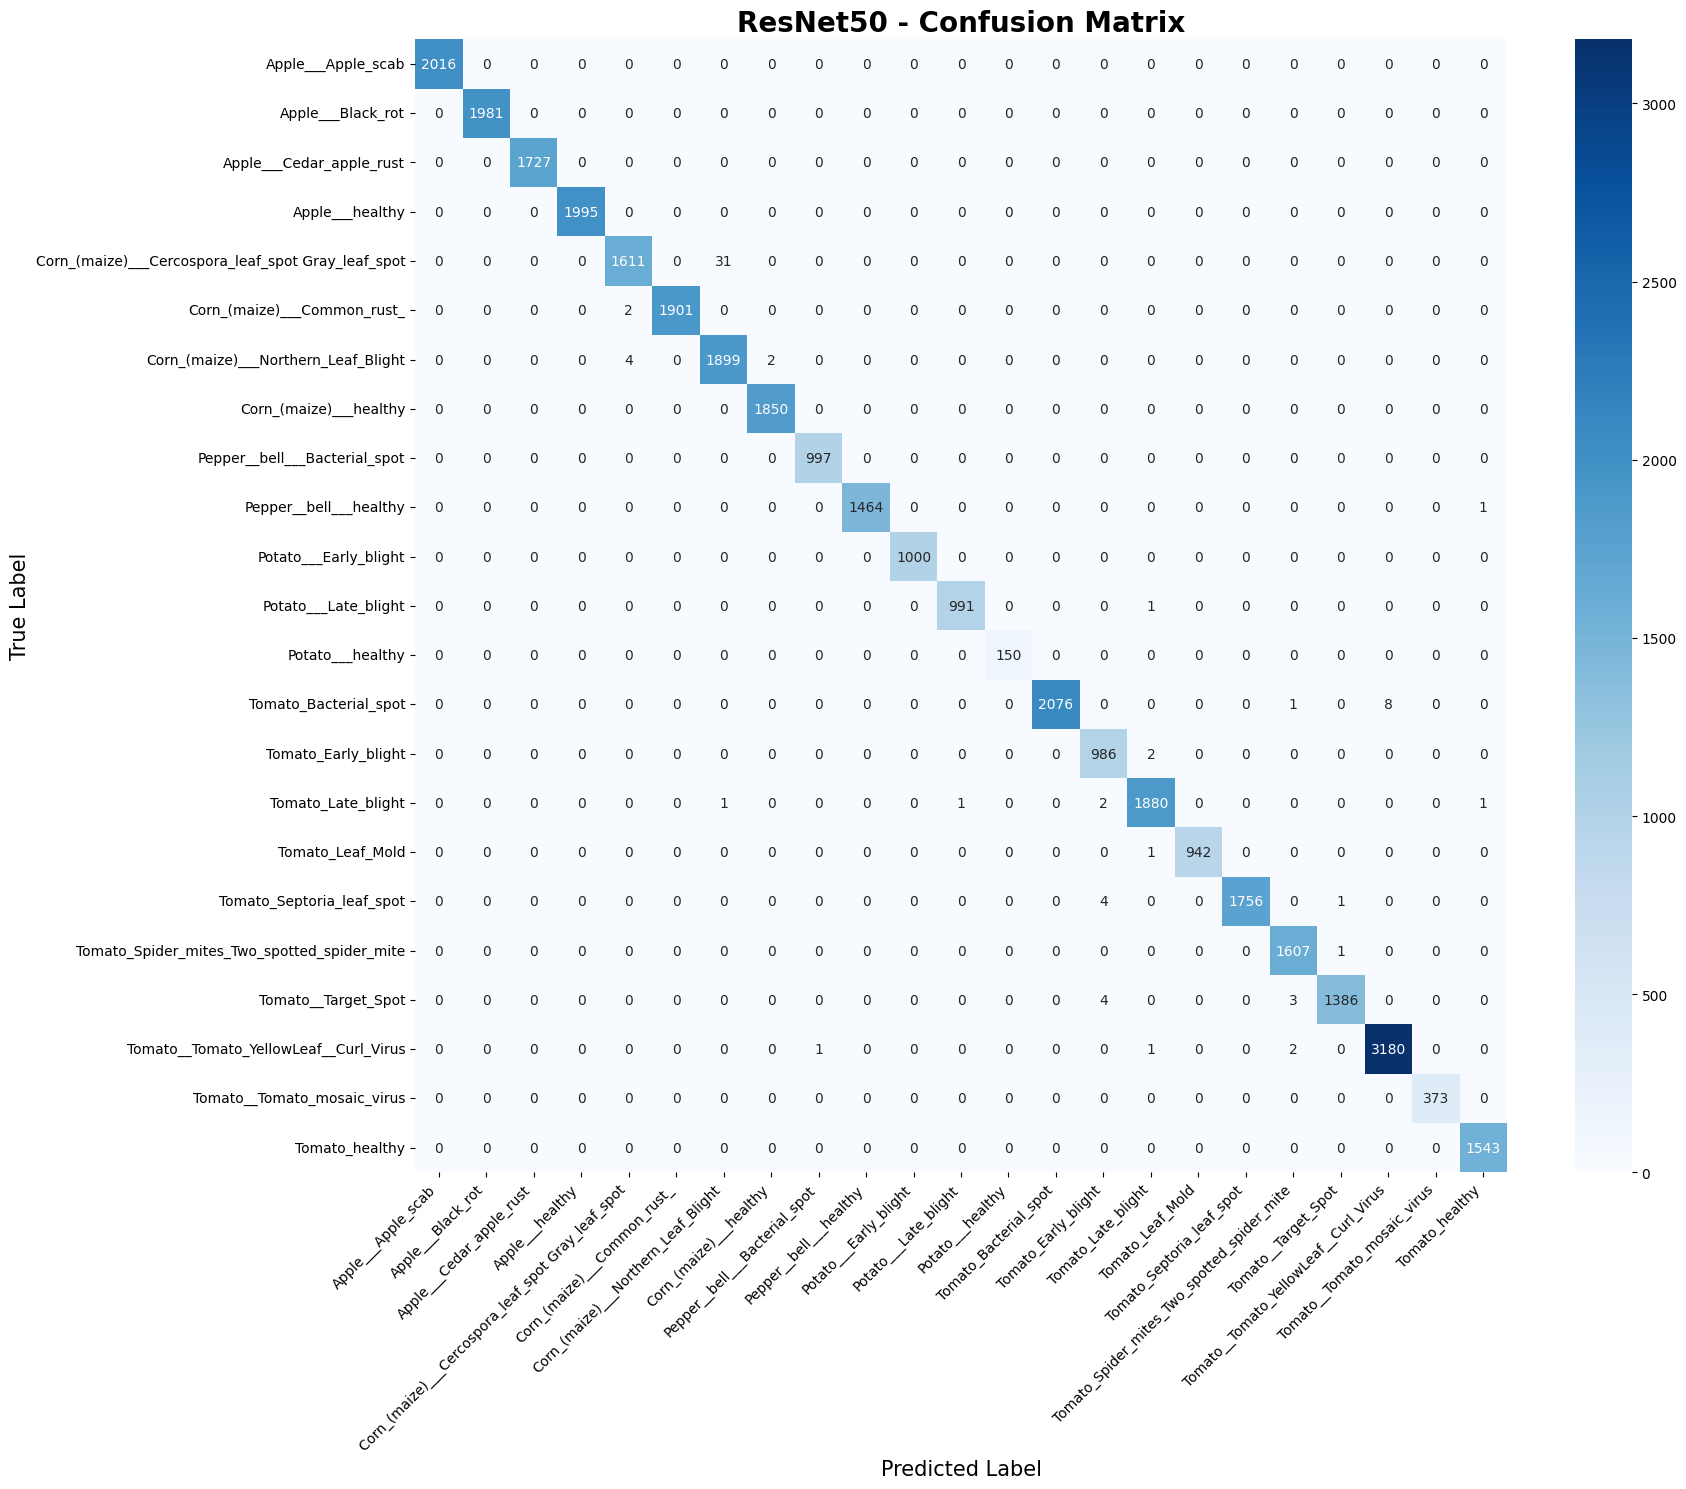

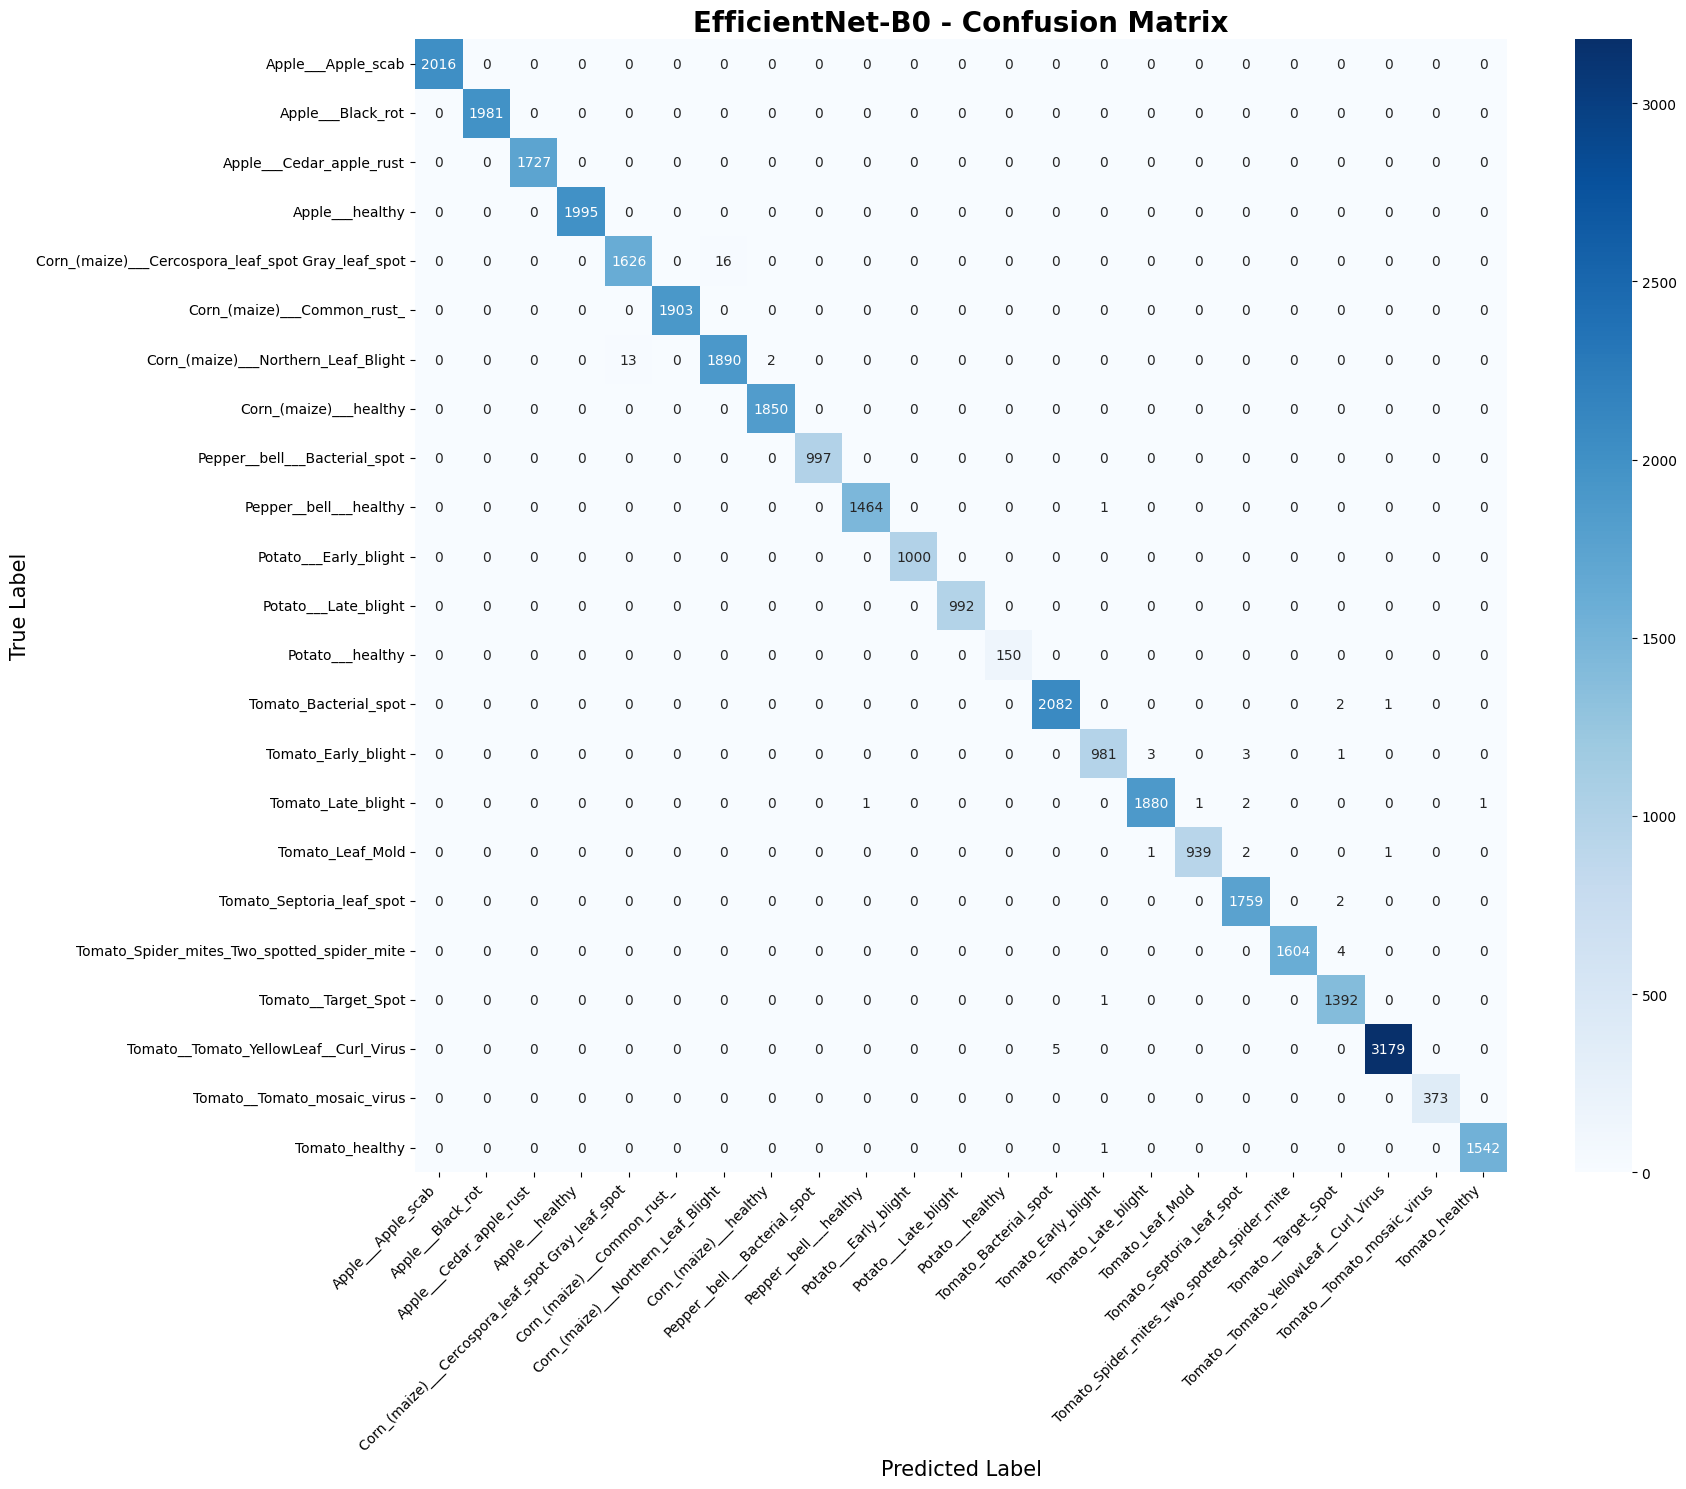

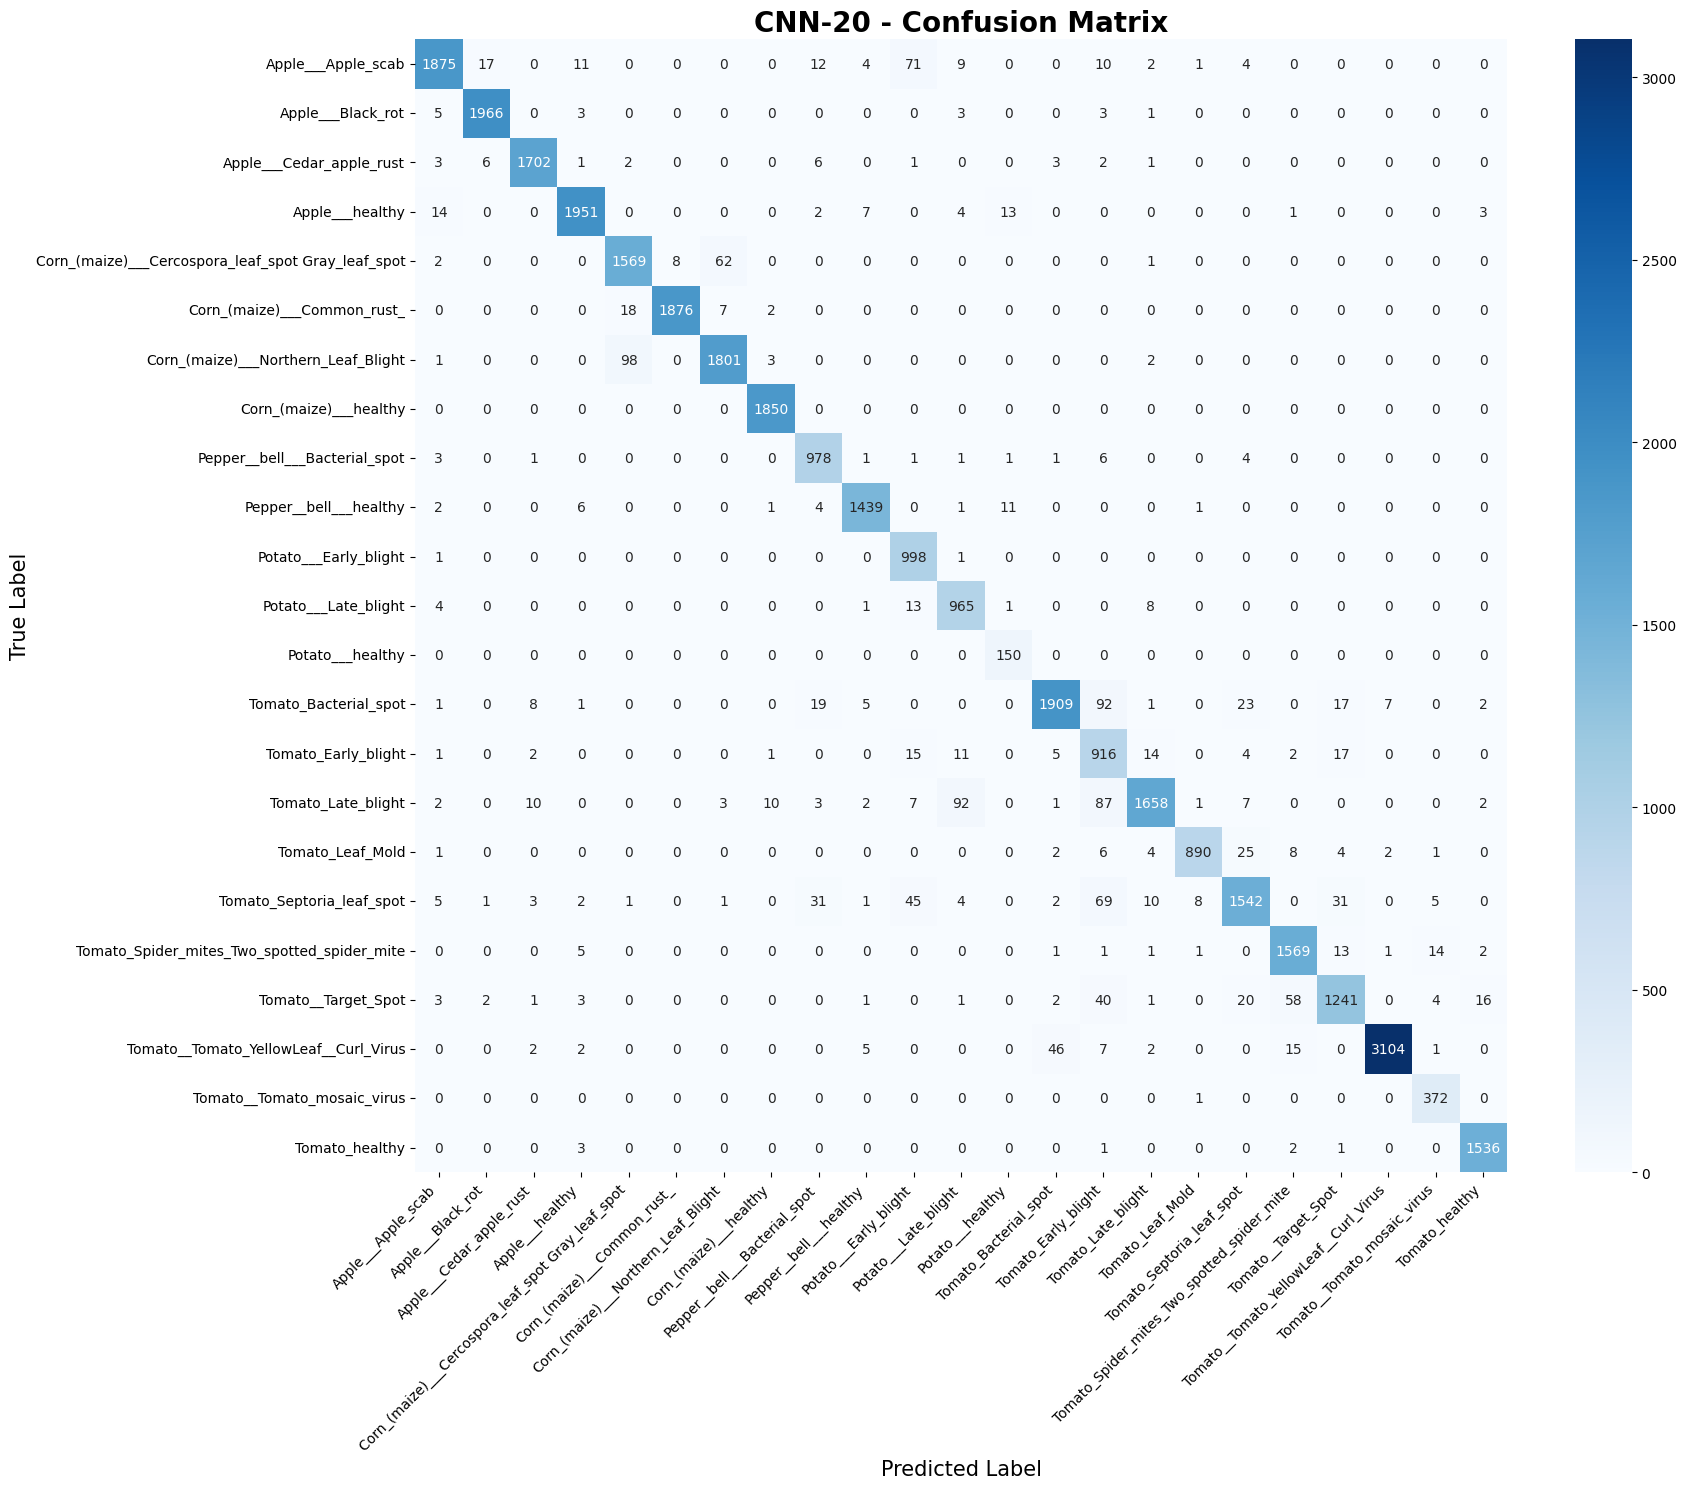

✓ All confusion matrices generated


In [13]:
def plot_confusion_matrix(y_true, y_pred, model_name, class_names):
    """Plot confusion matrix heatmap"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(18, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix', fontsize=20, fontweight='bold')
    plt.ylabel('True Label', fontsize=15)
    plt.xlabel('Predicted Label', fontsize=15)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot confusion matrices for all three models
print("Generating confusion matrices...\n")

plot_confusion_matrix(resnet_results['labels'], resnet_results['predictions'],
                     'ResNet50', class_names)

plot_confusion_matrix(efficientnet_results['labels'], efficientnet_results['predictions'],
                     'EfficientNet-B0', class_names)

plot_confusion_matrix(cnn20_results['labels'], cnn20_results['predictions'],
                     'CNN-20', class_names)

print("✓ All confusion matrices generated")

# 11. Cross-Validation (K-Fold) 

In [14]:
from sklearn.model_selection import KFold

RUN_CV = True  # Set to True to run CV (takes long time)

if RUN_CV:
    N_SPLITS = 5
    EPOCHS_PER_FOLD = 10

    print("\n" + "=" * 70)
    print(f"STARTING {N_SPLITS}-FOLD CROSS-VALIDATION")
    print("=" * 70)

    # Load full clean dataset
    CLEAN_DIR = os.path.join(ROOT, "data", "clean")
    train_tf = T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.RandomHorizontalFlip(0.5),
        T.RandomRotation(10),
        T.ColorJitter(0.1, 0.1, 0.05),
        T.ToTensor(),
        T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])
    
    clean_dataset_full = torchvision.datasets.ImageFolder(root=CLEAN_DIR, transform=train_tf)
    all_indices = np.arange(len(clean_dataset_full))

    kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

    # Store results for each fold
    cv_results = {
        'ResNet50': {'loss': [], 'accuracy': [], 'top3_acc': []},
        'EfficientNetB0': {'loss': [], 'accuracy': [], 'top3_acc': []},
        'Custom_CNN20': {'loss': [], 'accuracy': [], 'top3_acc': []}
    }

    for fold, (train_ids, val_ids) in enumerate(kfold.split(all_indices)):
        print(f"\n{'=' * 25} FOLD {fold + 1}/{N_SPLITS} {'=' * 25}")

        # Create data subsets for this fold
        train_subset = torch.utils.data.Subset(clean_dataset_full, train_ids)

        val_dataset_fold = torchvision.datasets.ImageFolder(root=CLEAN_DIR, transform=val_transform)
        val_subset = torch.utils.data.Subset(val_dataset_fold, val_ids)

        train_loader_fold = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True,
                                      num_workers=NUM_WORKERS, pin_memory=PIN)
        val_loader_fold = DataLoader(val_subset, batch_size=BATCH_SIZE * 2, shuffle=False,
                                    num_workers=NUM_WORKERS, pin_memory=PIN)

        # Evaluate ResNet50
        print("\nEvaluating ResNet50 on fold...")
        resnet_fold_results = evaluate_model_pytorch(resnet_model, val_loader_fold, device)
        cv_results['ResNet50']['loss'].append(resnet_fold_results['loss'])
        cv_results['ResNet50']['accuracy'].append(resnet_fold_results['accuracy'])
        cv_results['ResNet50']['top3_acc'].append(resnet_fold_results['top_k_accuracy'])
        print(f"  ResNet50 Fold {fold + 1} - Val Acc: {resnet_fold_results['accuracy']:.2f}%")

        # Evaluate EfficientNetB0
        print("\nEvaluating EfficientNet-B0 on fold...")
        eff_fold_results = evaluate_model_pytorch(efficientnet_model, val_loader_fold, device)
        cv_results['EfficientNetB0']['loss'].append(eff_fold_results['loss'])
        cv_results['EfficientNetB0']['accuracy'].append(eff_fold_results['accuracy'])
        cv_results['EfficientNetB0']['top3_acc'].append(eff_fold_results['top_k_accuracy'])
        print(f"  EfficientNet-B0 Fold {fold + 1} - Val Acc: {eff_fold_results['accuracy']:.2f}%")

        # Evaluate Custom CNN-20
        print("\nEvaluating CNN-20 on fold...")
        cnn20_fold_results = evaluate_model_pytorch(cnn20_model, val_loader_fold, device)
        cv_results['Custom_CNN20']['loss'].append(cnn20_fold_results['loss'])
        cv_results['Custom_CNN20']['accuracy'].append(cnn20_fold_results['accuracy'])
        cv_results['Custom_CNN20']['top3_acc'].append(cnn20_fold_results['top_k_accuracy'])
        print(f"  Custom CNN-20 Fold {fold + 1} - Val Acc: {cnn20_fold_results['accuracy']:.2f}%")

    # Per-fold summary DataFrame
    cv_summary = pd.DataFrame({
        'Fold': [f'Fold {i+1}' for i in range(N_SPLITS)],
        'ResNet50 Acc (%)': cv_results['ResNet50']['accuracy'],
        'EfficientNetB0 Acc (%)': cv_results['EfficientNetB0']['accuracy'],
        'CNN-20 Acc (%)': cv_results['Custom_CNN20']['accuracy'],
        'ResNet50 Loss': cv_results['ResNet50']['loss'],
        'EfficientNetB0 Loss': cv_results['EfficientNetB0']['loss'],
        'CNN-20 Loss': cv_results['Custom_CNN20']['loss'],
        'ResNet50 Top-3 Acc (%)': cv_results['ResNet50']['top3_acc'],
        'EfficientNetB0 Top-3 Acc (%)': cv_results['EfficientNetB0']['top3_acc'],
        'CNN-20 Top-3 Acc (%)': cv_results['Custom_CNN20']['top3_acc'],
    })

    print("\nPer-Fold Results:")
    display(cv_summary.style.format({
        'ResNet50 Acc (%)': '{:.2f}',
        'EfficientNetB0 Acc (%)': '{:.2f}',
        'CNN-20 Acc (%)': '{:.2f}',
        'ResNet50 Loss': '{:.4f}',
        'EfficientNetB0 Loss': '{:.4f}',
        'CNN-20 Loss': '{:.4f}',
        'ResNet50 Top-3 Acc (%)': '{:.2f}',
        'EfficientNetB0 Top-3 Acc (%)': '{:.2f}',
        'CNN-20 Top-3 Acc (%)': '{:.2f}',
    }))

    # Average results summary
    avg_results = pd.DataFrame({
        'Model': ['ResNet50', 'EfficientNetB0', 'Custom CNN-20'],
        'Avg Accuracy (%)': [
            np.mean(cv_results['ResNet50']['accuracy']),
            np.mean(cv_results['EfficientNetB0']['accuracy']),
            np.mean(cv_results['Custom_CNN20']['accuracy'])
        ],
        'Std Accuracy': [
            np.std(cv_results['ResNet50']['accuracy']),
            np.std(cv_results['EfficientNetB0']['accuracy']),
            np.std(cv_results['Custom_CNN20']['accuracy'])
        ],
        'Avg Loss': [
            np.mean(cv_results['ResNet50']['loss']),
            np.mean(cv_results['EfficientNetB0']['loss']),
            np.mean(cv_results['Custom_CNN20']['loss'])
        ],
        'Avg Top-3 Acc (%)': [
            np.mean(cv_results['ResNet50']['top3_acc']),
            np.mean(cv_results['EfficientNetB0']['top3_acc']),
            np.mean(cv_results['Custom_CNN20']['top3_acc'])
        ]
    })

    print("\nAverage Across All Folds:")
    display(avg_results.style.format({
        'Avg Accuracy (%)': '{:.2f}',
        'Std Accuracy': '{:.2f}',
        'Avg Loss': '{:.4f}',
        'Avg Top-3 Acc (%)': '{:.2f}'
    }).hide(axis="index"))

else:
    print("\n" + "=" * 70)
    print("Cross-Validation skipped (RUN_CV=False)")
    print("Set RUN_CV=True to run K-Fold Cross-Validation")
    print("Note: CV evaluates loaded models on different data splits")
    print("=" * 70)


STARTING 5-FOLD CROSS-VALIDATION

========================= FOLD 1/5 =========================

Evaluating ResNet50 on fold...
  ResNet50 Fold 1 - Val Acc: 99.77%

Evaluating EfficientNet-B0 on fold...
  ResNet50 Fold 1 - Val Acc: 99.77%

Evaluating EfficientNet-B0 on fold...
  EfficientNet-B0 Fold 1 - Val Acc: 99.77%

Evaluating CNN-20 on fold...
  EfficientNet-B0 Fold 1 - Val Acc: 99.77%

Evaluating CNN-20 on fold...
  Custom CNN-20 Fold 1 - Val Acc: 95.96%

========================= FOLD 2/5 =========================

Evaluating ResNet50 on fold...
  Custom CNN-20 Fold 1 - Val Acc: 95.96%

========================= FOLD 2/5 =========================

Evaluating ResNet50 on fold...
  ResNet50 Fold 2 - Val Acc: 99.68%

Evaluating EfficientNet-B0 on fold...
  ResNet50 Fold 2 - Val Acc: 99.68%

Evaluating EfficientNet-B0 on fold...
  EfficientNet-B0 Fold 2 - Val Acc: 99.86%

Evaluating CNN-20 on fold...
  EfficientNet-B0 Fold 2 - Val Acc: 99.86%

Evaluating CNN-20 on fold...
  Custom C

,Fold,ResNet50 Acc (%),EfficientNetB0 Acc (%),CNN-20 Acc (%),ResNet50 Loss,EfficientNetB0 Loss,CNN-20 Loss,ResNet50 Top-3 Acc (%),EfficientNetB0 Top-3 Acc (%),CNN-20 Top-3 Acc (%)
0,Fold 1,99.77,99.77,95.96,0.0077,0.0065,0.1296,100.00,100.00,99.73
1,Fold 2,99.68,99.86,95.78,0.0101,0.0066,0.1308,99.99,100.00,99.68
2,Fold 3,99.83,99.70,95.69,0.0080,0.0072,0.1258,100.00,100.00,99.69
3,Fold 4,99.80,99.84,95.76,0.0069,0.0047,0.1308,100.00,100.00,99.68
4,Fold 5,99.86,99.92,95.21,0.0064,0.0054,0.1377,100.00,100.00,99.59



Average Across All Folds:


Model,Avg Accuracy (%),Std Accuracy,Avg Loss,Avg Top-3 Acc (%)
ResNet50,99.79,0.06,0.0078,100.00
EfficientNetB0,99.82,0.07,0.0060,100.00
Custom CNN-20,95.68,0.25,0.1309,99.67


## 12. Export Notebook to HTML

In [19]:
# Export this notebook with outputs to HTML
import subprocess
from datetime import datetime

notebook_name = "ModelInference.ipynb"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_html = f"ModelInference_output_{timestamp}.html"

try:
    cmd = f'jupyter nbconvert --to html --no-input --no-prompt "{notebook_name}" --output "{output_html}"'
    print(f"Exporting notebook to HTML...")
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)

    if result.returncode == 0:
        print("")
    else:
        print(f"Note: Export command available, run manually if needed")
        print(f"Command: jupyter nbconvert --to html {notebook_name}")
except Exception as e:
    print(f"Manual export: File > Download as > HTML (.html)")



Exporting notebook to HTML...


